In [ ]:
import os
import numpy as np
import pandas as pd
import timm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from torchvision.utils import make_grid
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm
import seaborn as sns
import altair as alt
import random
from torch.cuda.amp import GradScaler, autocast


import warnings
warnings.filterwarnings("ignore")

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [ ]:
root_dir = '/kaggle/input/well-documented-alzheimers-dataset'

In [ ]:
class_count = {}

for dir in os.listdir(root_dir):
    dir_path = os.path.join(root_dir, dir)
    if os.path.isdir(dir_path):
        for labels in os.listdir(dir_path):
            count = 0
            labels_path = os.path.join(dir_path, labels)
            for image in os.listdir(labels_path):
                count += 1
            class_count[labels] = count

sorted_class_count = dict(sorted(class_count.items(), key=lambda item: item[0], reverse=False))

classes = [item[0] for item in sorted_class_count.items()]
class_count_list = [item[1] for item in sorted_class_count.items()]


sorted_class_count

In [ ]:
import pandas as pd
import altair as alt

# Create a DataFrame for visualization
data = pd.DataFrame({
    'Class': classes,
    'Count': class_count_list
})

# Create the bar chart
bar_chart = alt.Chart(data).mark_bar().encode(
    x=alt.X('Class:N', sort=None, title='Class'),
    y=alt.Y('Count:Q', title='Image Count'),
    color=alt.Color('Class:N', legend=None)
)

# Add text labels on top of the bars
text = bar_chart.mark_text(
    align='center',
    baseline='bottom',
    dy=-5  # Adjust the position of the text
).encode(
    text='Count:Q'
)

# Combine the bar chart and text labels
chart = (bar_chart + text).properties(
    title="Class Distribution",
    width=800,
    height=400
)

# Save and display the chart
chart.save('/kaggle/working/dataset_distribution.html')
chart.show()


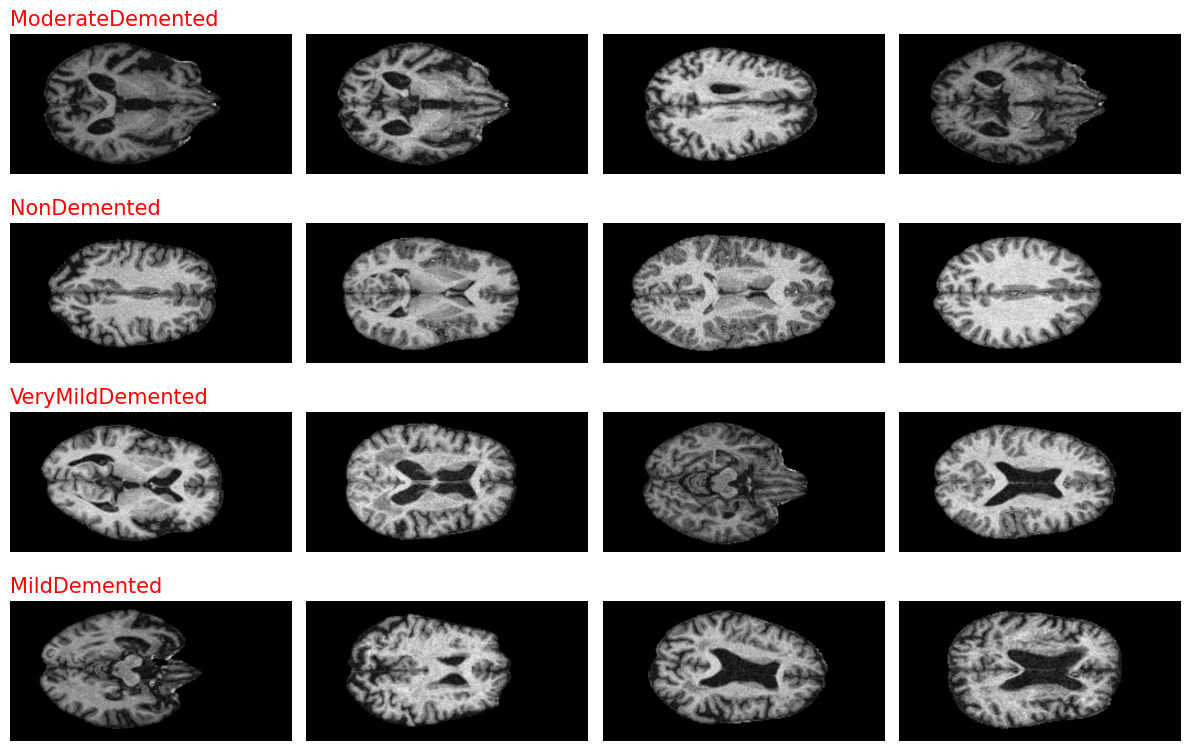

In [8]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def plot_sample_images(root_dir, start_index=5, num_samples=4, output_path="/kaggle/working/sample_images_plot.png"):
    classes = []
    class_images = {}
    valid_extensions = ('.png', '.jpg', '.jpeg')  # Add valid extensions

    # Traverse through classes
    for dir in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, dir)
        if os.path.isdir(dir_path):
            for label in os.listdir(dir_path):
                label_path = os.path.join(dir_path, label)
                if os.path.isdir(label_path):
                    images = []
                    for img_file in os.listdir(label_path):
                        if img_file.lower().endswith(valid_extensions):
                            images.append(os.path.join(label_path, img_file))
                    if images:
                        classes.append(label)
                        # Select images starting from the specified index
                        class_images[label] = images[start_index:start_index + num_samples]

    # Plot images
    num_classes = len(classes)
    fig, axes = plt.subplots(num_classes, num_samples, figsize=(num_samples * 3, num_classes * 2))

    for i, class_name in enumerate(classes):
        for j in range(num_samples):
            ax = axes[i, j] if num_classes > 1 else axes[j]
            ax.axis('off')
            if j < len(class_images[class_name]):
                img = Image.open(class_images[class_name][j])
                ax.imshow(img)
                if j == 0:  # Add label for the first column
                    ax.set_title(class_name, fontsize=15, color="red", loc="left")
    
    plt.subplots_adjust(hspace=0)  # Reduce vertical spacing between rows
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)  # Save the plot as PNG
    plt.show()

# Example usage
root_dir = '/kaggle/input/well-documented-alzheimers-dataset'
output_path = '/kaggle/working/sample_images_plot_final.png'
plot_sample_images(root_dir, start_index=12, num_samples=4, output_path=output_path)


In [ ]:
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Supported image extensions
        valid_extensions = ('.png', '.jpg')

        for dir in os.listdir(root_dir):
            dir_path = os.path.join(root_dir, dir)
            if os.path.isdir(dir_path):
                for label in os.listdir(dir_path):
                    labels_path = os.path.join(dir_path, label)
                    if os.path.isdir(labels_path):
                        for image in os.listdir(labels_path):
                            image_path = os.path.join(labels_path, image)
                            if os.path.isfile(image_path) and image_path.lower().endswith(valid_extensions):
                                self.images.append(image_path)
                                self.labels.append(label)

        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.encoded_labels[idx]

        try:
            # Load image and convert to RGB
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            raise RuntimeError(f"Error loading image {img_path}: {e}")

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_label_mapping(self):
        return dict(zip(self.label_encoder.classes_, range(len(self.label_encoder.classes_))))


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = CustomImageDataset(root_dir, transform=transform)

indices = list(range(len(dataset)))
labels = dataset.encoded_labels  # Labels already encoded in your CustomImageDataset

# First, split the dataset into 80% train and 20% test
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, stratify=labels, random_state=42
)

# Now, split the train dataset into 85% train and 15% validation
train_indices, val_indices = train_test_split(
    train_indices, test_size=0.15, stratify=[labels[i] for i in train_indices], random_state=42
)

# Create subsets for train, validation, and test
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Verify the splits
train_labels = [labels[i] for i in train_indices]
val_labels = [labels[i] for i in val_indices]
test_labels = [labels[i] for i in test_indices]

print("Train distribution:", {cls: train_labels.count(cls) for cls in set(labels)})
print("Validation distribution:", {cls: val_labels.count(cls) for cls in set(labels)})
print("Test distribution:", {cls: test_labels.count(cls) for cls in set(labels)})


In [ ]:
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

In [ ]:
from torch.utils.data import WeightedRandomSampler
import numpy as np

# Access labels of the original dataset corresponding to train_indices
train_labels = [labels[i] for i in train_indices]  # Use original labels, already defined

# Compute class counts and weights
class_counts = np.bincount(train_labels)  # Count instances per class
class_weights = 1.0 / class_counts  # Inverse class frequency

# Assign weights to each sample in the training set
sample_weights = [class_weights[label] for label in train_labels]

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(train_indices),  # Number of samples in the training set
    replacement=True  # Allow replacement for balanced sampling
)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32,sampler=sampler num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Total Batch for training {len(train_loader)}")

# Initialize and configure the training process

In [ ]:
from torchvision import models

Load the ResNet50 model
base_model = models.resnet50(pretrained=True)

# print(base_model)

In [ ]:
# Define the custom CNN model
class CustomCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (img_size // 8) * (img_size // 8), 512),  # Assuming input image size is divisible by 8
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Parameters
input_channels = 3  # e.g., RGB images
num_classes = 4
img_size = 224  # Image size (must match preprocessing)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the custom CNN model
model = CustomCNN(input_channels=input_channels, num_classes=num_classes).to(device)



In [ ]:
# Class Weighting (Weighted Loss Function)

# total_samples = sum(class_count_list)

# class_weights = [total_samples / (len(class_count_list) * count) for count in class_count_list]

# class_weights_tensor = torch.tensor(class_weights).float().to(device)

# criterion = nn.CrossEntropyLoss(label_smoothing=0.1,weight=class_weights_tensor).to(device)

In [ ]:
# Criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.01)

# Scaler for mixed-precision training
scaler = GradScaler()

# Training and validation loop
epochs = 10
patience = 3
min_delta = 0.001
best_val_accuracy = 0.0
counter = 0
early_stop = False

loss_dict = {"epoch": [], "train": [], "val": []}
accuracy_dict = {"epoch": [], "train": [], "val": []}


## Begin the training loop

In [ ]:
start = timeit.default_timer()

for epoch in range(epochs):
    
    epoch_start = timeit.default_timer()
    
    if early_stop:
        print("Early stopping triggered!")
        break

    model.train()
    train_loss = 0
    train_preds, train_labels = [], []

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training", leave=True)
    for batch_idx, batch in enumerate(train_loader_tqdm):
        images = batch[0].to(device)
        labels = batch[1].to(device)

        optimizer.zero_grad()
        with autocast():  # Added mixed-precision training context
            output = model(images)
            loss = criterion(output, labels)

        scaler.scale(loss).backward()

        # Gradient clipping to handle gradient explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        preds = torch.argmax(output, dim=1)
        train_preds.extend(preds.cpu().tolist())
        train_labels.extend(labels.cpu().tolist())

        train_accuracy = sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels)

        current_lr = scheduler.get_last_lr()[0]  # Get current learning rate
        train_loader_tqdm.set_postfix(train_loss=train_loss / (batch_idx + 1), 
                                      train_accuracy=train_accuracy, 
                                      lr=current_lr)  # Added learning rate to tqdm

    train_loss /= len(train_loader)
    train_accuracy = sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels)

    # Validation Phase
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    y_score = []
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} - Validation", leave=True)
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader_tqdm):
            images = batch[0].to(device)
            labels = batch[1].to(device)

            with autocast():  # Added mixed-precision inference
                output = model(images)
                loss = criterion(output, labels)

            val_loss += loss.item()
            preds = torch.argmax(output, dim=1)
            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(labels.cpu().tolist())
            
            # Collect probabilities for ROC AUC computation
            probs = torch.softmax(output, dim=1)
            y_score.extend(probs.cpu().numpy())
            
            val_accuracy = sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels)

            val_loader_tqdm.set_postfix(val_loss=val_loss / (batch_idx + 1), 
                                        val_accuracy=val_accuracy)

    val_loss /= len(val_loader)
    val_accuracy = sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels)

    loss_dict["epoch"].append(epoch + 1)
    loss_dict["train"].append(train_loss)
    loss_dict["val"].append(val_loss)

    accuracy_dict["epoch"].append(epoch + 1)
    accuracy_dict["train"].append(train_accuracy)
    accuracy_dict["val"].append(val_accuracy)

    scheduler.step()

    # Model Checkpointing with Best Validation Accuracy
    if val_accuracy > best_val_accuracy:  # Updated checkpoint condition to use accuracy
        best_val_accuracy = val_accuracy
        counter = 0

        model_name = f"model_checkpoint_epoch_{epoch + 1}_val_acc_{val_accuracy:.4f}_vit.pth"  # Updated checkpoint name

        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_dict': loss_dict,
            'accuracy_dict': accuracy_dict,
        }, model_name)
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping due to no improvement in validation accuracy")
        early_stop = True

    epoch_end = timeit.default_timer()
    epoch_duration = epoch_end - epoch_start

    print(f"Epoch {epoch + 1}/{epochs}: "
        f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
        f"Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%, "
        f"Duration: {epoch_duration / 60:.2f} min")
    
    torch.cuda.empty_cache()

stop = timeit.default_timer()
print(f"Total Training Time: {(stop - start) / 60:.2f} min")

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the true labels for multi-class ROC AUC computation
n_classes = len(set(val_labels))
y_true = label_binarize(val_labels, classes=range(n_classes))
y_score = np.array(y_score)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC AUC curve
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap("tab20", n_classes)

for i, color in enumerate(colors.colors[:n_classes]):
    plt.plot(
        fpr[i], tpr[i], color=color, lw=2,
        label=f"Class {i} (AUC = {roc_auc[i]:.2f})"
    )

plt.plot(
    fpr["micro"], tpr["micro"],
    label=f"Micro-average (AUC = {roc_auc['micro']:.2f})",
    color="deeppink", linestyle=":", linewidth=2
)

plt.plot([0, 1], [0, 1], color="navy", linestyle="--", lw=1.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)

# Save the plot
roc_auc_plot_path = '/kaggle/working/roc_auc_curve_fixed.png'
plt.savefig(roc_auc_plot_path)
plt.show()

print(f"ROC AUC curve saved at: {roc_auc_plot_path}")


In [ ]:
# Save metrics to a CSV file
metrics_df = pd.DataFrame({
    "epoch": loss_dict["epoch"],
    "train_loss": loss_dict["train"],
    "val_loss": loss_dict["val"],
    "train_accuracy": accuracy_dict["train"],
    "val_accuracy": accuracy_dict["val"]
})
metrics_df.to_csv("training_metrics_upsampling.csv", index=False)  # Added saving metrics to CSV

In [ ]:
model_name = f"model_checkpoint_epoch_{epoch + 1}_val_acc_{val_accuracy:.4f}_vit.pth"

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_dict': loss_dict,
    'accuracy_dict': accuracy_dict,
}, model_name)

print(f"Checkpoint saved as {model_name}")

In [ ]:
# Plotting loss
loss_data = pd.DataFrame({
    'Epoch': loss_dict['epoch'] * 2,
    'Value': loss_dict['train'] + loss_dict['val'],
    'Type': ['Training Loss'] * len(loss_dict['epoch']) + ['Validation Loss'] * len(loss_dict['epoch'])
})

# Calculate the mean value for centering the graph
mean_loss = loss_data['Value'].mean()

# Create loss chart with centered y-axis
loss_chart = alt.Chart(loss_data).mark_line(point=True).encode(
    x=alt.X('Epoch:O', title='Epoch'),
    y=alt.Y('Value:Q', title='Loss', scale=alt.Scale(domain=[mean_loss - 0.5, mean_loss + 0.5])),
    color=alt.Color('Type:N', title='Type'),
    tooltip=['Epoch', 'Value', 'Type']
).properties(
    title="Training and Validation Loss",
    width=700,
    height=400
).interactive()

# Save the plot
loss_chart.save('/kaggle/working/loss_plot.html')

loss_chart.show()

In [ ]:
# Plotting accuracy
accuracy_data = pd.DataFrame({
    'Epoch': accuracy_dict['epoch'] * 2,
    'Value': accuracy_dict['train'] + accuracy_dict['val'],
    'Type': ['Training Accuracy'] * len(accuracy_dict['epoch']) + ['Validation Accuracy'] * len(accuracy_dict['epoch'])
})

# Calculate the mean value for centering the graph
mean_accuracy = accuracy_data['Value'].mean()

# Create accuracy chart with centered y-axis
accuracy_chart = alt.Chart(accuracy_data).mark_line(point=True).encode(
    x=alt.X('Epoch:O', title='Epoch'),
    y=alt.Y('Value:Q', title='Accuracy', scale=alt.Scale(domain=[mean_accuracy - 0.1, mean_accuracy + 0.1])),
    color=alt.Color('Type:N', title='Type'),
    tooltip=['Epoch', 'Value', 'Type']
).properties(
    title="Training and Validation Accuracy",
    width=700,
    height=400
).interactive()

# Save the plot
accuracy_chart.save('/kaggle/working/accuracy_plot.html')

accuracy_chart.show()

# Initializing Test

In [ ]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [ ]:
with torch.no_grad():
    test_loss = 0
    total_correct = 0

    # Initialize lists to store labels and predictions
    all_labels = []
    all_preds = []

    # Get the size of the test dataset
    total_test_samples = len(test_loader.dataset)

    test_loader_tqdm = tqdm(test_loader, desc="Testing", leave=True)

    for batch_idx, batch in enumerate(test_loader_tqdm):
        images = batch[0].to(device)
        labels = batch[1].to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        total_correct += get_num_correct(outputs, labels)

        # Append labels and predictions to the lists
        all_labels.extend(labels.cpu().numpy())
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())

        # Update tqdm progress bar
        test_loader_tqdm.set_postfix(
            test_loss=f"{test_loss / (batch_idx + 1):.3f}",
            test_accuracy=f"{(total_correct / ((batch_idx + 1) * test_loader.batch_size)):.3f}",
            total_correct=total_correct
        )

    # Calculate average loss and accuracy
    test_loss /= len(test_loader)
    test_accuracy = total_correct / len(test_loader.dataset)

# Output the final results
print(f"Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}%, Total Correct: {total_correct}")

In [ ]:
cm = confusion_matrix(all_labels, all_preds, labels=range(4))

cm_df = pd.DataFrame(cm, columns=classes, index=classes)

# Reshape the confusion matrix DataFrame for Altair
cm_melted = cm_df.reset_index().melt(id_vars='index', var_name='Predicted', value_name='Count')
cm_melted = cm_melted.rename(columns={'index': 'True'})

# Adjust the tooltip to handle 23 classes clearly
tooltip_info = ['True:N', 'Predicted:N', 'Count:Q']

# Create confusion matrix heatmap using Altair with adaptive size
confusion_matrix_chart = alt.Chart(cm_melted).mark_rect().encode(
    x=alt.X('Predicted:N', title='Predicted Classes', sort=classes),
    y=alt.Y('True:N', title='True Classes', sort=classes),
    color=alt.Color('Count:Q', scale=alt.Scale(scheme='blues')),
    tooltip=tooltip_info
).properties(
    title='Confusion Matrix',
    width=700,  # Adjust width for 23 classes
    height=700  # Adjust height for 23 classes
)

# Add annotations inside the heatmap
text_annotations = alt.Chart(cm_melted).mark_text(size=10).encode(
    x='Predicted:N',
    y='True:N',
    text=alt.Text('Count:Q', format='.0f'),  # Format counts as integers
    color=alt.condition(
        alt.datum.Count > 3000,  # If Count > 0, use contrasting text color
        alt.value('white'), 
        alt.value('black')
    )
)

# Combine the heatmap and annotations
final_chart = confusion_matrix_chart + text_annotations

final_chart.save('/kaggle/working/confusion_matrix.html')

# Show the chart
final_chart.show()

In [ ]:
# Generate the classification report
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
print(report)
# Convert the classification report to a DataFrame
df_report = pd.DataFrame(report).transpose()

# Optionally save the report to a CSV for further analysis
df_report.to_csv("classification_report", index=True)

# Display the DataFrame
print("Classification Report:")
df_report